In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, roc_auc_score

sns.set(font_scale = 1.5)

from sklearn.ensemble import RandomForestClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.metrics import confusion_matrix

Выборка train - для постоения модели и оценки ее качества. Выборка test = для получения итоговых результатов по целевому столбцу.

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train.head(10)

,Tectonic_regime,Onshore/Offshore,Hydrocarbon_type,Reservoir_status,Structural_setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OFFSHORE,OIL,DEVELOPING,INVERSION/WRENCH,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0
1,GRAVITY/EXTENSION/EVAPORITE,OFFSHORE,OIL,MATURE PRODUCTION,SALT/PASSIVE MARGIN,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0
2,GRAVITY/EXTENSION/EVAPORITE,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
3,COMPRESSION,ONSHORE,OIL,DECLINING PRODUCTION,THRUST,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0
4,INVERSION/COMPRESSION/EXTENSION,ONSHORE,OIL,DECLINING PRODUCTION,INVERSION/RIFT,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0
5,COMPRESSION/EXTENSION/EVAPORITE,ONSHORE,OIL,DECLINING PRODUCTION,INTRACRATONIC,5575,CARBONIFEROUS,DOLOMITE,80.0,46.0,14.0,15.0
6,INVERSION/COMPRESSION/EXTENSION,ONSHORE,OIL,DEVELOPING,INVERSION/RIFT,5216,PROTEROZOIC,SANDSTONE,200.0,25.0,10.0,209.0
7,INVERSION/COMPRESSION/EXTENSION,OFFSHORE,OIL,DEVELOPING,RIFT,8100,CRETACEOUS,SANDSTONE,115.0,40.0,15.0,30.0
8,COMPRESSION,ONSHORE,OIL,DECLINING PRODUCTION,INTRACRATONIC,1915,CARBONIFEROUS,LIMESTONE,330.0,20.0,10.0,35.0
9,COMPRESSION,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,4150,PERMIAN,DOLOMITE,225.0,200.0,17.5,62.0


In [4]:
test = pd.read_csv("test.csv")

Отделим целевой столбец и преобразуем с помощью LabelEncoder. Для удобства дальнейшего анализа и преобразования признаков объединим test и train в общий массив data.

In [5]:
train_x=train.drop("Onshore/Offshore", axis = 1)
train_y = train["Onshore/Offshore"]

In [6]:
le = preprocessing.LabelEncoder()
le.fit(train_y)
y = le.transform(train_y)
y = pd.DataFrame(y)

In [7]:
data = pd.concat([train_x, test], ignore_index=True)

In [8]:
data.head(5)

,Tectonic_regime,Hydrocarbon_type,Reservoir_status,Structural_setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OIL,DEVELOPING,INVERSION/WRENCH,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0
1,GRAVITY/EXTENSION/EVAPORITE,OIL,MATURE PRODUCTION,SALT/PASSIVE MARGIN,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0
2,GRAVITY/EXTENSION/EVAPORITE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
3,COMPRESSION,OIL,DECLINING PRODUCTION,THRUST,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0
4,INVERSION/COMPRESSION/EXTENSION,OIL,DECLINING PRODUCTION,INVERSION/RIFT,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0


Пропусков нет

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
Tectonic_regime       442 non-null object
Hydrocarbon_type      442 non-null object
Reservoir_status      442 non-null object
Structural_setting    442 non-null object
Depth                 442 non-null int64
Period                442 non-null object
Lithology             442 non-null object
Gross                 442 non-null float64
Netpay                442 non-null float64
Porosity              442 non-null float64
Permeability          442 non-null float64
dtypes: float64(4), int64(1), object(6)
memory usage: 38.1+ KB


In [10]:
data.describe()

,Depth,Gross,Netpay,Porosity,Permeability
count,442.000000,442.000000,442.000000,442.000000,442.000000
mean,6613.658371,784.540724,189.061946,17.929955,469.916425
std,3572.468358,1442.899648,282.161279,7.554253,1017.081304
min,220.000000,11.000000,0.000000,1.100000,0.010000
25%,3824.500000,135.750000,43.000000,12.000000,10.000000
50%,6137.500000,328.000000,100.000000,17.900000,79.500000
75%,9071.500000,748.750000,206.500000,24.000000,400.000000
max,19888.000000,12500.000000,2976.000000,55.000000,7500.000000


Обработка категориальных признаков Tectonic_regime, Structural_setting и Period.

1. Tectonic regime

In [11]:
data.Tectonic_regime.value_counts()

COMPRESSION                                    96
EXTENSION                                      44
COMPRESSION/EROSION                            40
COMPRESSION/EVAPORITE                          35
INVERSION/COMPRESSION/EXTENSION                32
                                               ..
EXTENSION/TRANSTENSION                          1
COMPRESSION/EXTENSION/LINKED/EROSION            1
GRAVITY/SHALE/EXTENSION                         1
STRIKE-SLIP/INVERSION/COMPRESSION/EXTENSION     1
COMPRESSION/STRIKE-SLIP/BASEMENT-I              1
Name: Tectonic_regime, Length: 61, dtype: int64

In [12]:
Tectonic_regime = data.Tectonic_regime.str.split('/')

In [13]:
Tectonic_list = ['COMPRESSION','EXTENSION','INVERSION','GRAVITY','STRIKE-SLIP','TRANSPRESSION','TRANSTENSION','EVAPORITE',\
                 'UPLIFT','EROSION','SHALE','BASEMENT-I','EVAPORITE','LINKED','SYNSEDIMENTATION','DIAPIR']

In [14]:
tectonic_data = pd.DataFrame()
for n in range(442):
    for element in Tectonic_list:
        if element in Tectonic_regime[n]:
            tectonic_data.at[n,element] = 1
        else: tectonic_data.at[n,element] = 0

In [15]:
tectonic_data.head(5)

,COMPRESSION,EXTENSION,INVERSION,GRAVITY,STRIKE-SLIP,TRANSPRESSION,TRANSTENSION,EVAPORITE,UPLIFT,EROSION,SHALE,BASEMENT-I,LINKED,SYNSEDIMENTATION,DIAPIR
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. Structural setting

In [16]:
Structural_setting = data.Structural_setting.str.split('/')

In [17]:
Structural_list = ['FORELAND', 'RIFT','SALT','INTRACRATONIC','INVERSION','THRUST','DELTA', 'PASSIVE MARGIN','WRENCH',\
                   'SUB-SALT','SUB-THRUST','BACKARC','FOREARC']

In [18]:
Structural_data = pd.DataFrame()
for n in range(442):
    for element in Structural_list:
        if element in Structural_setting[n]:
            Structural_data.at[n,element] = 1
        else: Structural_data.at[n,element] = 0

In [19]:
Structural_data.head(5)

,FORELAND,RIFT,SALT,INTRACRATONIC,INVERSION,THRUST,DELTA,PASSIVE MARGIN,WRENCH,SUB-SALT,SUB-THRUST,BACKARC,FOREARC
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3. Period

In [20]:
period = data.Period.str.replace('-','/')

In [21]:
period = period.str.split('/')

In [22]:
period_list = ['CRETACEOUS', 'NEOGENE','JURASSIC','PALEOGENE','CARBONIFEROUS','PERMIAN','DEVONIAN','TRIASSIC',\
               'PROTEROZOIC','ORDOVICIAN','SILURIAN','CAMBRIAN','PALEOZOIC','ARCHEAN','MESOZOIC']


In [23]:
period_data = pd.DataFrame()
for n in range(442):
    for element in period_list:
        if element in period[n]:
            period_data.at[n,element] = 1
        else: period_data.at[n,element] = 0

In [24]:
period_data.head(5)

,CRETACEOUS,NEOGENE,JURASSIC,PALEOGENE,CARBONIFEROUS,PERMIAN,DEVONIAN,TRIASSIC,PROTEROZOIC,ORDOVICIAN,SILURIAN,CAMBRIAN,PALEOZOIC,ARCHEAN,MESOZOIC
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Анализ числовых признаков

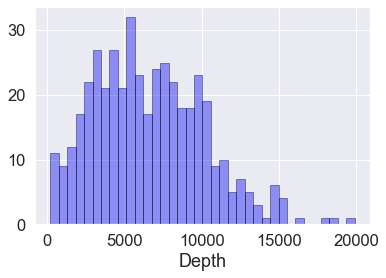

In [25]:
sns.distplot(data['Depth'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

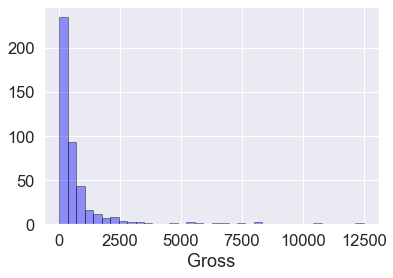

In [26]:
sns.distplot(data['Gross'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

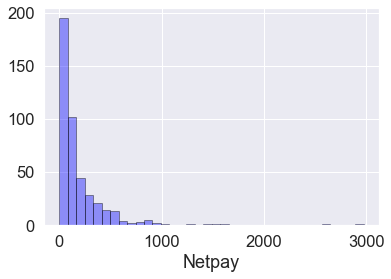

In [27]:
sns.distplot(data['Netpay'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [28]:
data_numeric=data[['Depth','Gross','Netpay','Porosity','Permeability']]
data_categorical=data[['Hydrocarbon_type','Reservoir_status','Lithology']]

In [29]:
data_categorical

,Hydrocarbon_type,Reservoir_status,Lithology
0,OIL,DEVELOPING,SANDSTONE
1,OIL,MATURE PRODUCTION,LIMESTONE
2,OIL,MATURE PRODUCTION,LIMESTONE
3,OIL,DECLINING PRODUCTION,SANDSTONE
4,OIL,DECLINING PRODUCTION,SANDSTONE
...,...,...,...
437,OIL,DECLINING PRODUCTION,SANDSTONE
438,BITUMEN,CONTINUING DEVELOPMENT,SANDSTONE
439,OIL,NEARLY DEPLETED,THINLY-BEDDED SANDSTONE
440,OIL,SECOND PLATEAU PRODUTION,SANDSTONE


In [30]:
#normalized_data = preprocessing.normalize(data_numeric)
#normalized_data = pd.DataFrame(normalized_data)

#standardized_data = preprocessing.scale(data_numeric)
#standardized_data = pd.DataFrame(standardized_data)

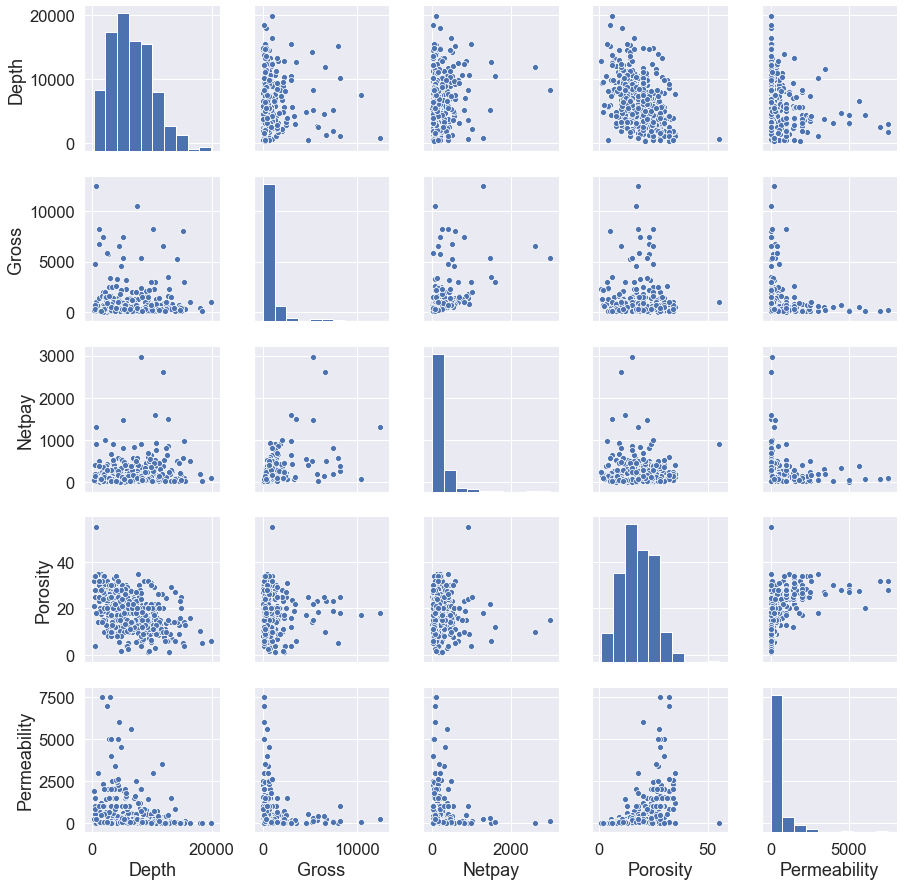

In [31]:
sns.pairplot(data_numeric)

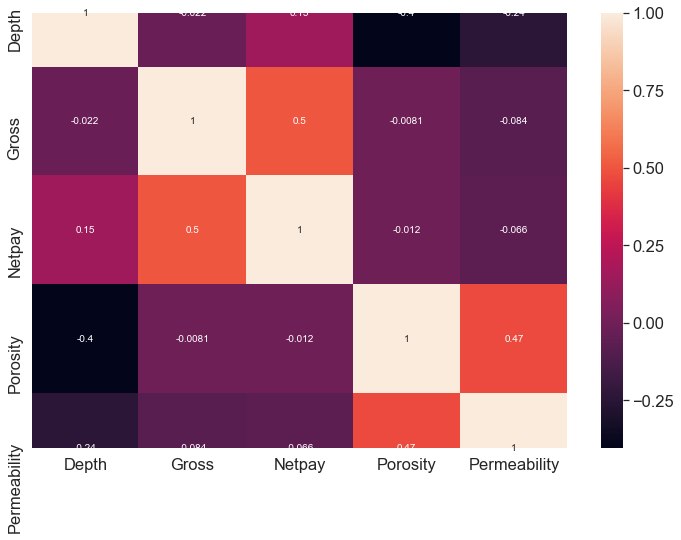

In [32]:
plt.figure(figsize=(12,8))
corrMatrix = data_numeric.corr()
sns.heatmap (corrMatrix, annot = True)


Обработка остальных категориальных признаков методом one-hot-encoding.

In [33]:
data_cat_1he = pd.get_dummies(data_categorical)

Объединим все обработанные признаки в dataframe new_data.

In [34]:
new_data = pd.concat([data_numeric, data_cat_1he, tectonic_data, Structural_data,period_data], axis = 1) 


In [35]:
new_data.head(5)

,Depth,Gross,Netpay,Porosity,Permeability,Hydrocarbon_type_BITUMEN,Hydrocarbon_type_CARBON DIOXIDE,Hydrocarbon_type_GAS,Hydrocarbon_type_GAS-CONDENSATE,Hydrocarbon_type_METHANE HYDRATE,...,PERMIAN,DEVONIAN,TRIASSIC,PROTEROZOIC,ORDOVICIAN,SILURIAN,CAMBRIAN,PALEOZOIC,ARCHEAN,MESOZOIC
0,3520,2460.0,220.0,20.0,45.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9967,427.0,160.0,19.0,175.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8700,95.0,15.0,12.0,20.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5084,328.0,300.0,13.0,600.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1030,260.0,33.0,24.0,182.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
new_data.columns = range(new_data.shape[1])

Обратно разделим выборку на обучающую и итоговую.

In [41]:
x_train = new_data[0:309]
x_test = new_data[309:]

Проверим баланс классов

In [42]:
y[0].value_counts()/y.size

1    0.682848
0    0.300971
2    0.016181
Name: 0, dtype: float64

Выборка не сбалансирована, поэтому будем добавлять данные, чтобы сбалансировать ее.

In [43]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(x_train, y)

print('Добавлено' ,X_ros.shape[0] - x_train.shape[0], 'новых точек')

Добавлено 324 новых точек


In [44]:
#smote = SMOTE(k_neighbors=2)
#X_sm, y_sm = smote.fit_sample(X_train, y)

Теперь разделим дополненную выборку для обучения на обучающую и валидационную.

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_ros, y_ros,test_size = 0.33, random_state = 42)

Построение модели машинного обучения

1. Градиентный бустинг

In [46]:
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_val)
#print (classification_report(y_val, y_pred))

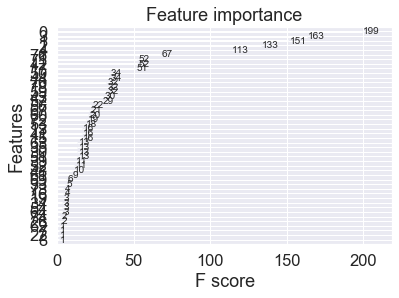

In [47]:
xgb.plot_importance(model)

In [48]:
accuracy_score(y_val, y_pred)

0.9138755980861244

Проверим правильность определения классов

Confusion matrix:
 [[66  5  0]
 [12 63  1]
 [ 0  0 62]]


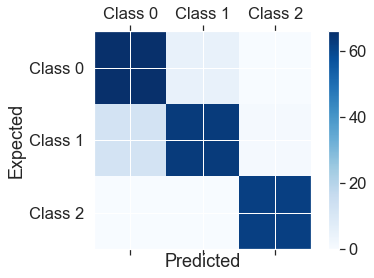

In [49]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1', 'Class 2']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Подбор гиперпараметров

In [51]:
model = XGBClassifier()
model

XGBClassifier()

In [52]:
params = {
        'min_child_weight': [1, 3, 6],
        'colsample_bytree': [0,1,0.5, 1],
        'max_depth': [ 6, 8, 10],
        'n_estimators': [ 100, 150, 200],
        'learning_rate': [ 0.001, 0.01, 0.1]
        }

In [53]:
clf = GridSearchCV(model, params, n_jobs=-1, 
                   cv=5, 
                   scoring='accuracy',
                   verbose=3, refit=True)
clf

GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0, 1, 0.5, 1],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [6, 8, 10], 'min_child_weight': [1, 3, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=3)

In [54]:
clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 701 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1341 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0, 1, 0.5, 1],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [6, 8, 10], 'min_child_weight': [1, 3, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=3)

In [55]:
clf.best_params_
best_boosting = clf.best_estimator_
best_boosting

XGBClassifier(colsample_bytree=0.5, max_depth=6, n_estimators=200,
              objective='multi:softprob')

In [56]:
y_pred = best_boosting.predict(X_val)

In [57]:
accuracy_score(y_val, y_pred)

0.9282296650717703

2. RandomForest

In [63]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train.values.ravel())

y_pred = random_forest.predict(X_val)
#print (classification_report(y_val, y_pred))

In [64]:
accuracy_score(y_val, y_pred)

0.937799043062201

Confusion matrix:
 [[69  2  0]
 [11 65  0]
 [ 0  0 62]]


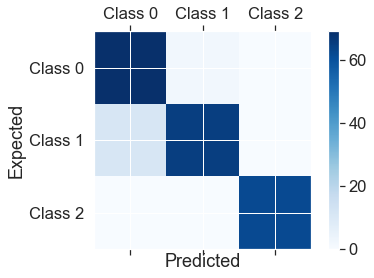

In [65]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1', 'Class 2']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Подбор гиперпараметров

In [66]:
model = RandomForestClassifier()
model

RandomForestClassifier()

In [67]:
params = { 
    'n_estimators': [100,200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,10,15,25,30],
    'criterion' :['gini', 'entropy']
}

In [68]:
clf = GridSearchCV(model, params, n_jobs=-1, 
                   cv=5, 
                   scoring='accuracy',
                   verbose=3, refit=True)
clf

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 10, 15, 25, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=3)

In [69]:
clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   28.2s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 10, 15, 25, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=3)

In [70]:
clf.best_params_
best_forest = clf.best_estimator_
best_forest

RandomForestClassifier(max_depth=15, max_features='log2')

In [71]:
y_pred1 = best_forest.predict(X_val)

In [72]:
accuracy_score(y_val, y_pred1)

0.937799043062201

Для итоговой выборки получим финальный результат и сохраним его в нужном формате.

In [73]:
resultat = best_forest.predict(x_test)

In [74]:
result = []
for element in resultat:
    if element == 0:
        result.append('OFFSHORE')
    elif element == 1:
        result.append('ONSHORE')
    else: result.append('ONSHORE-OFFSHORE')

In [75]:
Y = pd.DataFrame(result, index =None)

In [76]:
Y.head(5)

,0
0,ONSHORE
1,ONSHORE
2,ONSHORE
3,OFFSHORE
4,ONSHORE


In [ ]:
Y.to_csv('prediction.csv',index=False)